In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [2]:
path_estreams = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_part_b\data\EStreams'

In [3]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'\streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [4]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [5]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [6]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

100%|██████████| 1/1 [00:00<?, ?it/s]


In [7]:
catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR003253", # Luneville
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR003271", # Nomeny
                    "FR000171", # Metz
                    "FR003272", # Hanconcourt
                    "FR003283", # Rosselange
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "DEBU1957", #Fremersdorf
                    "FR003308", #Niedaltdorf
                    "FR003301", # Wittring
                    "FR003304", # Bliesbruck
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2017", # Hentern
                    "DEBU1958", # Trier
                    "DERP2024", # Kordel
                    "DERP2033", # Plein
                    "DEBU1959", # Cochem
                    "DERP2011", #Alsdorf 
                    "DERP2003", # Bollendorf
                    "DERP2007"] # Pruem

catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR000171", # Metz
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "FR003301", # Wittring
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2024", # Kordel
                    "DEBU1959", # Cochem
                    "DERP2011"] #Alsdorf 

catchments_ids = ["DEBU1958", # Trier                    
                  "FR003272", # Hanconcourt
                  "DEBU1957", # Fremersdorf
                  "DERP2003", # Bollendorf
                  "FR003308", # Niedaltdorf
                  "FR003283", # Rosselange
                  "FR003253", # Luneville
                  "FR003271", # Nomeny
                  "DERP2033", # Plein
                  "DERP2017", # Hentern
                  "FR003304", # Bliesbruck
                  "DERP2007"] # Pruem

# Catchments used in the original Moselle paper (only)
catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR003253", # Luneville
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR003271", # Nomeny
                    "FR000171", # Metz
                    "FR003272", # Hanconcourt
                    "FR003283", # Rosselange
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "DEBU1957", #Fremersdorf
                    "FR003308", #Niedaltdorf
                    "FR003301", # Wittring
                    #"FR003304", # Bliesbruck
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2017", # Hentern
                    "DEBU1958", # Trier
                    "DERP2024", # Kordel
                    "DERP2033", # Plein
                    "DEBU1959", # Cochem
                    "DERP2011", #Alsdorf 
                    "DERP2003", # Bollendorf
                    "DERP2007", # Pruem
                    "FR000184", # New
                    "FR003303", # New
                    'DERP2013',# New
                    'FR000144',# New
                    ] 
# Nalbach MISSING
# Reinheim MISSING

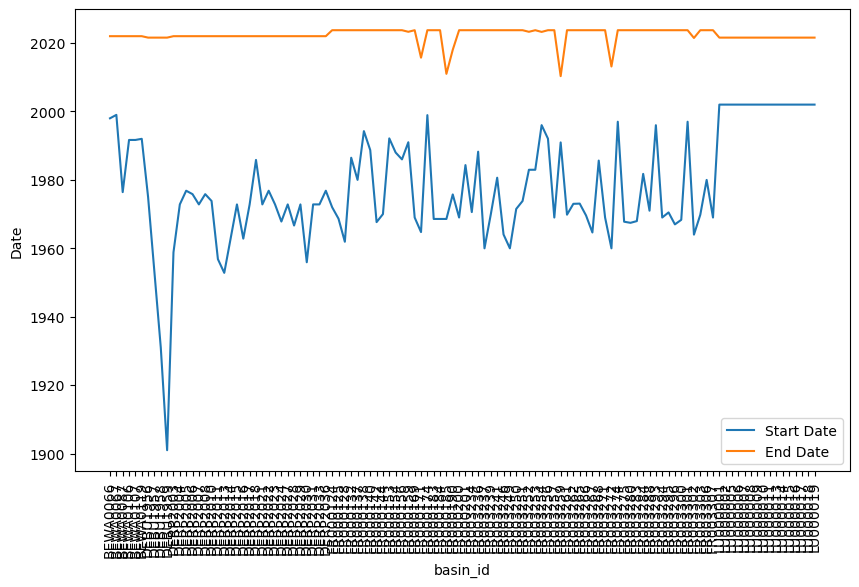

In [8]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot start_date and end_date on the same graph
estreams_attributes_clipped_filters.start_date.plot(ax=ax, label="Start Date")
estreams_attributes_clipped_filters.end_date.plot(ax=ax, label="End Date")

# Make y-axis label vertical
ax.set_ylabel("Date", rotation=90)

# Ensure ALL x-axis ticks are shown
ax.set_xticks(np.arange(len(estreams_attributes_clipped_filters)))  # Set all x-ticks
ax.set_xticklabels(estreams_attributes_clipped_filters.index, rotation=90)  # Rotate labels

# Add legend
ax.legend()

# Show plot
plt.show()


In [9]:
# Python implementation
from david2022 import FastReservoirPower, FastReservoirLinear
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [10]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

In [11]:
import numba as nb
from superflexpy.framework.element import ODEsElement
from copy import deepcopy
import numba as nb
from superflexpy.framework.element import ODEsElement
from copy import deepcopy

class CustomUnsaturatedReservoir(UnsaturatedReservoir):
    """
    This class implements the UnsaturatedReservoir of HBV.
    """

    def __init__(self, parameters, states, approximation, id):
        
        """
        This is the initializer of the class UnsaturatedReservoir.

        Parameters
        ----------
        parameters : dict
            Parameters of the element. The keys must be:
            'Smax' : maximum reservoir storage
            'Ce' : Potential evapotranspiration multiplier
            'm' : Smoothing factor for evapotranspiration
            'beta' : Exponent in the relation for the streamflow
        states : dict
            Initial state of the element. The keys must be:
            - 'S0' : initial storage of the reservoir.
        approximation : superflexpy.utils.numerical_approximation.NumericalApproximator
            Numerial method used to approximate the differential equation
        id : str
            Itentifier of the element. All the elements of the framework must
            have an id.
        """

        ODEsElement.__init__(self, parameters=parameters, states=states, approximation=approximation, id=id)

        self._fluxes_python = [self._fluxes_function_python]

        if approximation.architecture == "numba":
            self._fluxes = [self._fluxes_function_numba]
        elif approximation.architecture == "python":
            self._fluxes = [self._fluxes_function_python]


    # METHODS FOR THE USER

    def set_input(self, input):
        """
        Set the input of the element.

        Parameters
        ----------
        input : list(numpy.ndarray)
            List containing the input fluxes of the element. It contains 2
            fluxes:
            1. Rainfall
            2. PET
        """

        self.input = {"P": input[0], "PET": input[1]}

    def get_output(self, solve=True):
        """
        This method solves the differential equation governing the routing
        store.

        Returns
        -------
        list(numpy.ndarray)
            Output fluxes in the following order:
            1. Streamflow (Q)
        """

        if solve:
            self._solver_states = [self._states[self._prefix_states + "S0"]]

            self._solve_differential_equation()

            # Update the state
            self.set_states({self._prefix_states + "S0": self.state_array[-1, 0]})

        fluxes = self._num_app.get_fluxes(
            fluxes=self._fluxes_python,
            S=self.state_array,
            S0=self._solver_states,
            dt=self._dt,
            **self.input,
            **{k[len(self._prefix_parameters) :]: self._parameters[k] for k in self._parameters},
        )

        return [-fluxes[0][2]]

    def get_AET(self):
        """
        This method calculates the actual evapotranspiration

        Returns
        -------
        numpy.ndarray
            Array of actual evapotranspiration
        """

        try:
            S = self.state_array
        except AttributeError:
            message = "{}get_aet method has to be run after running ".format(self._error_message)
            message += "the model using the method get_output"
            raise AttributeError(message)

        fluxes = self._num_app.get_fluxes(
            fluxes=self._fluxes_python,
            S=S,
            S0=self._solver_states,
            dt=self._dt,
            **self.input,
            **{k[len(self._prefix_parameters) :]: self._parameters[k] for k in self._parameters},
        )

        return [-fluxes[0][1]]

    # PROTECTED METHODS

    @staticmethod
    def _fluxes_function_python(S, S0, ind, P, Csmax, Ce, m, bacon, beta, PET, dt):
        # TODO: handle time variable parameters (Smax) -> overflow
        Smax = Csmax * bacon

        if ind is None:
            return (
                [
                    P,
                    -Ce * PET * ((S / Smax) * (1 + m)) / ((S / Smax) + m),
                    -P * (S / Smax) ** beta,
                ],
                0.0,
                S0 + P * dt,
            )
        else:
            Smax[ind] = Csmax[ind] * bacon[ind]

            return (
                [
                    P[ind],
                    -Ce[ind] * PET[ind] * ((S / Smax[ind]) * (1 + m[ind])) / ((S / Smax[ind]) + m[ind]),
                    -P[ind] * (S / Smax[ind]) ** beta[ind],
                ],
                0.0,
                S0 + P[ind] * dt[ind],
                [
                    0.0,
                    -(Ce[ind] * PET[ind] * m[ind] * (m[ind] + 1) * Smax[ind]) / ((S + m[ind] * Smax[ind]) ** 2),
                    -(P[ind] * beta[ind] / Smax[ind]) * (S / Smax[ind]) ** (beta[ind] - 1),
                ],
            )

    @staticmethod
    @nb.jit(
        "Tuple((UniTuple(f8, 3), f8, f8,UniTuple(f8, 3)))"
        "(optional(f8), f8, i4, f8[:], f8[:], f8[:], f8[:], f8[:], f8[:], f8[:], f8[:])",
        nopython=True,
    )
    def _fluxes_function_numba(S, S0, ind, P, Csmax, Ce, m, bacon, beta, PET, dt):
        # TODO: handle time variable parameters (Smax) -> overflow
        Smax = Csmax * bacon
        
        return (
            (
                P[ind],
                -Ce[ind] * PET[ind] * ((S / Smax[ind]) * (1 + m[ind])) / ((S / Smax[ind]) + m[ind]),
                -P[ind] * (S / Smax[ind]) ** beta[ind],
            ),
            0.0,
            S0 + P[ind] * dt[ind],
            (
                0.0,
                -(Ce[ind] * PET[ind] * m[ind] * (m[ind] + 1) * Smax[ind]) / ((S + m[ind] * Smax[ind]) ** 2),
                -(P[ind] * beta[ind] / Smax[ind]) * (S / Smax[ind]) ** (beta[ind] - 1),
            ),
        )

In [12]:
def assign_parameter_values(parameters_name_model, parameter_names, parameters):
    """
    Assigns values from `parameters` to `parameters_name_model` where a match exists in `parameter_names`,
    but keeps any parameters that have three segments (`X_Y_Z`) unchanged.

    Args:
        parameters_name_model (list): List of full parameter names (e.g., "general_slow_k").
        parameter_names (list): List of unique parameter names (e.g., "slow_k", "high_slow_k").
        parameters (list): List of values corresponding to `parameter_names`.

    Returns:
        dict: Dictionary {parameter_name_model: assigned_value}, where:
            - `X_Y` parameters are updated from `parameter_names`.
            - `X_Y_Z` parameters are kept unchanged.
    """
    # Create a dictionary mapping parameter_names to their corresponding values
    param_value_dict = {param_name: value for param_name, value in zip(parameter_names, parameters)}

    # Build the output dictionary
    filtered_parameters = {}

    for param_name in parameters_name_model:
        parts = param_name.split("_")  # Split the name to check structure
        base_name = "_".join(parts[-2:])  # Extract last two parts (X_Y)
        
        if base_name in param_value_dict:  # If X_Y is in parameter_names
            filtered_parameters[param_name] = param_value_dict[base_name]
        elif param_name in parameter_names:  # Direct match in parameter_names (X_Y)
            filtered_parameters[param_name] = param_value_dict[param_name]
    
    return filtered_parameters  # Return dictionary of matched parameters


class spotpy_model(object):

    def __init__(self, model, catchments, dt, observations, parameters, parameter_names, parameter_names_model, output_index, warm_up=365):

        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            model (Network): SuperflexPy network containing multiple nodes.
            catchments (list): List of Node objects.
            inputs (dict): Dictionary with inputs for each node.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._model = model  # The SuperflexPy network
        self._catchments = catchments  # List of catchments
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names
        self._parameter_names_model = parameter_names_model  # Store full parameter names

        # Store inputs and observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the entire network using the same parameter set and collects per-node outputs."""

        # Convert parameter list into a dictionary
        #named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
        
        # Check if parameters have changed (avoid unnecessary computations)
        if not hasattr(self, "_cached_params") or not np.array_equal(self._cached_params, parameters):
            self._cached_params = np.array(parameters)  # Store the current parameters
            named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
            self._model.set_parameters(named_parameters)  # Apply shared parameters

        # Apply shared parameters to the whole network (this is due to the way we set Csumax)
        for key in model._content_pointer.keys():
            i = model._content_pointer[key] 
            self._model._content[i].set_parameters(named_parameters)
        #self._model.set_parameters(named_parameters)

        # Set timestep and reset the network
        self._model.set_timestep(self._dt)
        self._model.reset_states()

        # Run the full network
        output = self._model.get_output()  # Get outputs for all nodes

        # Return outputs as a list (one per node)
        return [output[cat.id][self._output_index] for cat in self._catchments]

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for sim, cat in zip(simulation, self._catchments):
            node_id = cat.id
            obs = evaluation[node_id]

            # Apply warm-up period
            sim = sim[self._warm_up + 1:]
            obs = obs[self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error

In [13]:
best_params_dict_model_g_1 = {'high_snow_k': 2.951239163078684,
 'high_unsaturated_Smax': 133.6270446707589,
 'high_unsaturated_Ce': 1.0049078746194,
 'high_unsaturated_beta': 0.9245542072624129,
 'high_slowhigh_k': 4.811426542930949e-05,
 'general_snow_k': 2.951239163078684,
 'general_unsaturated_Smax': 133.6270446707589,
 'general_unsaturated_Ce': 1.0049078746194,
 'general_unsaturated_beta': 0.9245542072624129,
 'general_lowersplitter_splitpar': 0.7996787281758282,
 'general_slow_k': 0.0997601739133764,
 'general_lag-fun_lag-time': 2.6620131067315693,
 'general_fast_k': 0.14102579773930624,
 'low_snow_k': 2.951239163078684,
 'low_unsaturated_Smax': 133.6270446707589,
 'low_unsaturated_Ce': 1.0049078746194,
 'low_unsaturated_beta': 0.9245542072624129,
 'low_fast_k': 0.0018833960901255783}

In [14]:
best_params_dict_model_r_1 = {'high_snow_k': 3.0299550544593896, 
 'high_unsaturated_Smax': 198.7065316996024, 
 'high_unsaturated_Ce': 1.0443103416089536, 
 'high_unsaturated_beta': 0.6735489844559259, 
 'high_slowhigh_k': 0.00017400005045443073, 
 'general_snow_k': 3.0299550544593896, 
 'general_unsaturated_Smax': 198.7065316996024, 
 'general_unsaturated_Ce': 1.0443103416089536, 
 'general_unsaturated_beta': 0.6735489844559259, 
 'general_lowersplitter_splitpar': 0.5054812580936748, 
 'general_slow_k': 0.07369493835864671, 
 'general_lag-fun_lag-time': 2.9242823443934185, 
 'general_fast_k': 0.18236744558042536, 
 'low_snow_k': 3.0299550544593896, 
 'low_unsaturated_Smax': 198.7065316996024, 
 'low_unsaturated_Ce': 1.0443103416089536, 
 'low_unsaturated_beta': 0.6735489844559259, 
 'low_fast_k': 0.004820579750897062}

In [15]:
best_params_dict_model_c_1 = {'high_snow_k': 3.088052765435262, 
 'high_unsaturated_Smax': 130.27168382276136, 
 'high_unsaturated_Ce': 0.9101212234463737, 
 'high_unsaturated_beta': 1.1535577371418388, 
 'high_slowhigh_k': 1.7926135478468055e-05, 
 'general_snow_k': 3.088052765435262, 
 'general_unsaturated_Smax': 130.27168382276136, 
 'general_unsaturated_Ce': 0.9101212234463737, 
 'general_unsaturated_beta': 1.1535577371418388, 
 'general_lowersplitter_splitpar': 0.8039354996369321, 
 'general_slow_k': 0.09381483588121267, 
 'general_lag-fun_lag-time': 2.9901369930310864, 
 'general_fast_k': 0.15403590988869115, 
 'low_snow_k': 3.088052765435262, 
 'low_unsaturated_Smax': 130.27168382276136, 
 'low_unsaturated_Ce': 0.9101212234463737, 
 'low_unsaturated_beta': 1.1535577371418388, 
 'low_fast_k': 0.002635072785799486}

In [16]:
best_params_dict_model_r_WD_1 = {'high_snow_k': 2.9507026488764536, 
 'high_unsaturated_Csmax': 0.5030060433171164, 
 'high_unsaturated_Ce': 1.0715224712904532, 
 'high_unsaturated_beta': 0.5287721375050809, 
 'high_slowhigh_k': 0.0007300129075967071, 
 'general_snow_k': 2.9507026488764536, 
 'general_unsaturated_Csmax': 0.5030060433171164, 
 'general_unsaturated_Ce': 1.0715224712904532, 
 'general_unsaturated_beta': 0.5287721375050809, 
 'general_lowersplitter_splitpar':0.6841612068821364, 
 'general_slow_k': 0.047561199823814876, 
 'general_lag-fun_lag-time': 2.9243831639147215, 
 'general_fast_k': 0.23304188550770044, 
 'low_snow_k': 2.9507026488764536, 
 'low_unsaturated_Csmax': 0.5030060433171164, 
 'low_unsaturated_Ce': 1.0715224712904532, 
 'low_unsaturated_beta': 0.5287721375050809, 
 'low_fast_k': 0.0036779558008492924}

In [17]:
best_params_dict_model_r_RD_1 = {'high_snow_k': 2.9027711175771698, 
 'high_unsaturated_Csmax': 1.1376085492381527, 
 'high_unsaturated_Ce': 0.7949753315835646, 
 'high_unsaturated_beta': 1.9744506192000117, 
 'high_slowhigh_k': 8.522456479715732e-06, 
 'general_snow_k': 2.9027711175771698, 
 'general_unsaturated_Csmax': 1.1376085492381527, 
 'general_unsaturated_Ce': 0.7949753315835646, 
 'general_unsaturated_beta': 1.9744506192000117, 
 'general_lowersplitter_splitpar':0.6669800745603109, 
 'general_slow_k': 0.09778841542231148, 
 'general_lag-fun_lag-time': 2.9813066284617067, 
 'general_fast_k': 0.16004460939658344, 
 'low_snow_k': 2.9027711175771698, 
 'low_unsaturated_Csmax': 1.1376085492381527, 
 'low_unsaturated_Ce': 0.7949753315835646, 
 'low_unsaturated_beta': 1.9744506192000117, 
 'low_fast_k': 0.004043116606489764}

In [18]:
best_params_dict_model_g_RD_1 = {'high_snow_k': 3.3915527582812945, 
 'high_unsaturated_Csmax': 1.1166878311308015, 
 'high_unsaturated_Ce': 0.9731825047175235, 
 'high_unsaturated_beta': 1.090651056262741, 
 'high_slowhigh_k': 3.0119872003195482e-05, 
 'general_snow_k': 3.3915527582812945, 
 'general_unsaturated_Csmax': 1.1166878311308015, 
 'general_unsaturated_Ce': 0.9731825047175235, 
 'general_unsaturated_beta': 1.090651056262741, 
 'general_lowersplitter_splitpar':0.6783488700643141, 
 'general_slow_k': 0.09933750575157357, 
 'general_lag-fun_lag-time': 2.65341354180656, 
 'general_fast_k': 0.13885792193704757, 
 'low_snow_k': 3.3915527582812945, 
 'low_unsaturated_Csmax': 1.1166878311308015, 
 'low_unsaturated_Ce': 0.9731825047175235, 
 'low_unsaturated_beta': 1.090651056262741, 
 'low_fast_k': 0.002071120694781522}

In [13]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_2001_2015'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'\\perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()

In [19]:
#catchments_ids = second_half_df.index.tolist()
#catchments_ids = first_half_df.index.tolist()
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

def run_model_superflexpy_wd_rd(catchments_ids, best_params_dict_model, perm_areas, waterdeficit_mean):
    
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']
    

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes

    for cat_id in catchments_ids:


        unsaturated = CustomUnsaturatedReservoir(
            parameters={'Csmax': 1.5, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0, 'bacon': waterdeficit_mean[cat_id].round(1)},
            states={'S0': 10.0},
            approximation=num_app,
            id='unsaturated')


        general = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [lower_splitter],
                [slow, lag_fun],
                [lower_transparent, fast],
                [lower_junction],
            ],
            id='general'
        )

        low = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [fast],
            ],
            id='low'
        )

        high = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [slowhigh],
            ],
            id='high'
        )

        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        
        node.set_input(inputs[cat_id])  # Correct way to set inputs
        
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        #globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )


    model.reset_states()

    model.set_timestep(1.0)

    # Apply shared parameters to the whole network (this is due to the way we set Csumax)
    for key in model._content_pointer.keys():
        i = model._content_pointer[key] 
        model._content[i].set_parameters(best_params_dict_model)

    #model.set_parameters(best_params_dict_model)

    #hyd_mod.reset_states()
    output = model.get_output()

    return output


def run_model_superflexpy_wd(catchments_ids, best_params_dict_model, perm_areas, waterdeficit_mean):
    
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']
    

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes

    for cat_id in catchments_ids:


        unsaturated = CustomUnsaturatedReservoir(
            parameters={'Csmax': 1.5, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0, 'bacon': waterdeficit_mean[cat_id].round(1)},
            states={'S0': 10.0},
            approximation=num_app,
            id='unsaturated')


        general = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [lower_splitter],
                [slow, lag_fun],
                [lower_transparent, fast],
                [lower_junction],
            ],
            id='general'
        )

        low = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [fast],
            ],
            id='low'
        )

        high = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [slowhigh],
            ],
            id='high'
        )

        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        
        node.set_input(inputs[cat_id])  # Correct way to set inputs
        
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        #globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )


    model.reset_states()

    model.set_timestep(1.0)

    # Apply shared parameters to the whole network (this is due to the way we set Csumax)
    for key in model._content_pointer.keys():
        i = model._content_pointer[key] 
        model._content[i].set_parameters(best_params_dict_model)

    #model.set_parameters(best_params_dict_model)

    #hyd_mod.reset_states()
    output = model.get_output()

    return output

def run_model_superflexpy(catchments_ids, best_params_dict_model, perm_areas):

    root_finder = PegasusNumba()
    num_app = ImplicitEulerNumba(root_finder=root_finder)

    class ParameterizedSingleFluxSplitter(ParameterizedElement):
        _num_downstream = 2
        _num_upstream = 1
        
        def set_input(self, input):

            self.input = {'Q_in': input[0]}

        def get_output(self, solve=True):

            split_par = self._parameters[self._prefix_parameters + 'splitpar']

            output1 = [self.input['Q_in'] * split_par]
            output2 = [self.input['Q_in'] * (1 - split_par)]
            
            return [output1, output2]   
        
        
    lower_splitter = ParameterizedSingleFluxSplitter(
        parameters={'splitpar': 0.5},
        id='lowersplitter'
    )

    # Fluxes in the order P, T, PET
    upper_splitter = Splitter(
        direction=[
            [0, 1, None],    # P and T go to the snow reservoir
            [2, None, None]  # PET goes to the transparent element
        ],
        weight=[
            [1.0, 1.0, 0.0],
            [0.0, 0.0, 1.0]
        ],
        id='upper-splitter'
    )

    snow = SnowReservoir(
        parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
        states={'S0': 0.0},
        approximation=num_app,
        id='snow'
    )

    upper_transparent = Transparent(
        id='upper-transparent'
    )

    upper_junction = Junction(
        direction=[
            [0, None],
            [None, 0]
        ],
        id='upper-junction'
    )


    unsaturated = UnsaturatedReservoir(
        parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
        states={'S0': 10.0},
        approximation=num_app,
        id='unsaturated'
    )

    fast = PowerReservoir(
        parameters={'k': 0.01, 'alpha': 2.0},
        states={'S0': 0.0},
        approximation=num_app,
        id='fast'
    )

    slow = PowerReservoir(
        parameters={'k': 1e-4, 'alpha': 1.0},
        states={'S0': 0.0},
        approximation=num_app,
        id='slow'
    )

    slowhigh = PowerReservoir(
        parameters={'k': 1e-4, 'alpha': 2.0},
        states={'S0': 0.0},
        approximation=num_app,
        id='slowhigh'
    )


    lower_junction = Junction(
        direction=[
            [0, 0]
        ],
        id='lower-junction'
    )

    lag_fun = HalfTriangularLag(
        parameters={'lag-time': 4.0},
        states={'lag': None},
        id='lag-fun'
    )

    lower_transparent = Transparent(
        id='lower-transparent'
    )

    general = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
        ],
        id='general'
    )

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low'
    )

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high'
    )

    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes
    
    for cat_id in catchments_ids:
        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )

    model.reset_states()

    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs


    #best_params_dict['M4_lowersplitter_split-par'] = 0.5


    model.set_timestep(1.0)
    model.set_parameters(best_params_dict_model)

    #hyd_mod.reset_states()
    output = model.get_output()

    return output

def generate_nse_results(catchments_ids, daterange, output):


    # Create an empty list to store results
    nse_results_cal = []

    for basin in catchments_ids:
        Qtimeseries = pd.DataFrame(index=daterange)
        Qtimeseries["Qobs"] = observations[basin]
        Qtimeseries["Qcalc"] = output[basin][0]

        nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                    simulation=Qtimeseries.iloc[365:, 1].values, 
                                    expo=0.5)
        
        mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
        mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
        bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        
        try:
            bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
            
            nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    expo=0.5)
        except:
            nse_value_bfi = np.nan


        nse_results_cal.append({
            "gauge_name": network_estreams.loc[basin, "gauge_name"],
            "basin": basin,
            "nse": nse_value,
            "q_mean_obs": mean_q_obs,
            "q_mean_calc": mean_q_calc,
            "bfi_obs": bfi_obs,
            "bfi_sim":bfi_sim,
            "nse_value_bfi": nse_value_bfi
            })

    # Convert results to DataFrame
    nse_results_cal_c_1_100 = pd.DataFrame(nse_results_cal)

    return nse_results_cal_c_1_100

In [20]:
def generate_kge_results(catchments_ids, daterange, output):


    # Create an empty list to store results
    kge_results_cal = []

    for basin in catchments_ids:
        Qtimeseries = pd.DataFrame(index=daterange)
        Qtimeseries["Qobs"] = observations[basin]
        Qtimeseries["Qcalc"] = output[basin][0]

        kge_value = 1 - obj_fun_kge(observations=Qtimeseries.iloc[365:, 0].values, 
                                    simulation=Qtimeseries.iloc[365:, 1].values)
        
        mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
        mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
        bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        
        try:
            bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
            
            kge_value_bfi = 1 - obj_fun_kge(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    )
        except:
            kge_value_bfi = np.nan


        kge_results_cal.append({
            "gauge_name": network_estreams.loc[basin, "gauge_name"],
            "basin": basin,
            "kge": kge_value,
            "q_mean_obs": mean_q_obs,
            "q_mean_calc": mean_q_calc,
            "bfi_obs": bfi_obs,
            "bfi_sim":bfi_sim,
            "kge_value_bfi": kge_value_bfi
            })

    # Convert results to DataFrame
    kge_results_cal_c_1_100 = pd.DataFrame(kge_results_cal)

    return kge_results_cal_c_1_100

In [21]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_2001_2015'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'\\perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()

In [ ]:
    catchments_ids = ['FR000184',
    'DERP2017',
    'DERP2011',
    'DERP2013',
    'DERP2007',
    'DERP2024',
    'FR003253',
    'FR003308',
    'FR003283',
    'FR003301',
    'DERP2003',
    'FR003265',
    'FR003272',
    'DEBU1958']

In [22]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_2001_2015'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'\\perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()


output_regional_wd = run_model_superflexpy_wd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_WD_1, perm_areas = perm_areas, waterdeficit_mean = waterdeficit_mean)
output_regional_rd = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_RD_1, perm_areas = perm_areas, waterdeficit_mean = rootdepth_mean)
output_regional = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas = perm_areas)
#output_global_rd = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_RD_1, perm_areas = perm_areasglobal, waterdeficit_mean = rootdepth_mean)

nse_results_cal_r_1_100_wd = generate_nse_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_regional_wd)
nse_results_cal_r_1_100_rd = generate_nse_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_regional_rd)
nse_results_cal_r_1_100 = generate_nse_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_regional)
#nse_results_cal_g_1_100_rd = generate_nse_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_global_rd)


In [199]:
#kge_results_cal_r_1_100_wd = generate_kge_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_regional_wd)
#kge_results_cal_r_1_100_rd = generate_kge_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_regional_rd)
kge_results_cal_r_1_100 = generate_kge_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_regional)

In [200]:
kge_results_cal_r_1_100

,gauge_name,basin,kge,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,kge_value_bfi
0,Reuland,BEWA0066,0.699140,1.224479,1.127816,0.511429,0.557320,0.803394
1,Schoenberg,BEWA0067,0.572401,1.397246,1.226372,0.443161,0.540013,0.795201
2,Martelange,BEWA0087,-7.396192,0.192824,1.176069,0.708779,0.525158,NaN
3,Reuland,BEWA0106,0.561368,0.986279,0.875000,0.473400,0.560178,NaN
4,Lommersweiler,BEWA0107,0.810843,1.134366,1.211335,0.565604,0.553497,NaN
...,...,...,...,...,...,...,...,...
107,Michelau,LU000015,0.725316,1.020046,0.986005,0.517760,0.555506,0.790997
108,Pfaffenthal,LU000016,0.670559,0.791896,0.717942,0.563590,0.562215,0.743936
109,Rosport,LU000017,0.719419,0.925885,0.867238,0.574924,0.598715,0.935955
110,Schoenfels,LU000018,0.439712,0.868880,0.768449,0.543259,0.649665,0.629050


In [197]:
kge_results_cal_r_1_100_wd

,gauge_name,basin,kge,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,kge_value_bfi
0,Reuland,BEWA0066,0.703738,1.224479,1.220441,0.511429,0.579886,0.776796
1,Schoenberg,BEWA0067,0.600655,1.397246,1.343739,0.443161,0.557846,0.737170
2,Martelange,BEWA0087,-7.460849,0.192824,1.251043,0.708779,0.550492,NaN
3,Reuland,BEWA0106,0.529084,0.986279,0.917836,0.473400,0.590243,NaN
4,Lommersweiler,BEWA0107,0.756421,1.134366,1.311516,0.565604,0.582488,NaN
...,...,...,...,...,...,...,...,...
107,Michelau,LU000015,0.691668,1.020046,1.038389,0.517760,0.581931,0.735308
108,Pfaffenthal,LU000016,0.358601,0.791896,0.603577,0.563590,0.665154,0.833010
109,Rosport,LU000017,0.642501,0.925885,0.882141,0.574924,0.632822,0.905725
110,Schoenfels,LU000018,0.284853,0.868880,0.687840,0.543259,0.686202,0.715108


In [198]:
kge_results_cal_r_1_100_rd

,gauge_name,basin,kge,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,kge_value_bfi
0,Reuland,BEWA0066,0.897331,1.224479,1.287726,0.511429,0.527890,0.862851
1,Schoenberg,BEWA0067,0.772254,1.397246,1.390542,0.443161,0.512718,0.799792
2,Martelange,BEWA0087,-10.000400,0.192824,1.344930,0.708779,0.486090,NaN
3,Reuland,BEWA0106,0.808797,0.986279,1.003217,0.473400,0.514694,NaN
4,Lommersweiler,BEWA0107,0.688425,1.134366,1.404717,0.565604,0.526716,NaN
...,...,...,...,...,...,...,...,...
107,Michelau,LU000015,0.830846,1.020046,1.128416,0.517760,0.514793,0.832218
108,Pfaffenthal,LU000016,0.748818,0.791896,0.723445,0.563590,0.558435,0.410243
109,Rosport,LU000017,0.890663,0.925885,0.939308,0.574924,0.584494,0.752073
110,Schoenfels,LU000018,0.395564,0.868880,0.732000,0.543259,0.688493,0.667129


<Axes: >

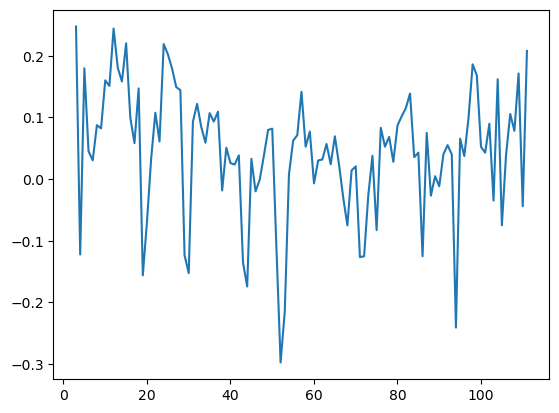

In [205]:
(kge_results_cal_r_1_100_rd.kge - kge_results_cal_r_1_100.kge).iloc[3:].plot()

In [226]:
nse_results_cal_g_1_100_rd.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\4002440395.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_g_1_100_rd.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.173899,-0.054178,-0.192180,-0.204267,0.924226
q_mean_obs,0.173899,1.000000,0.926245,0.018471,-0.045644,0.235554
q_mean_calc,-0.054178,0.926245,1.000000,0.055930,0.105970,0.102422
bfi_obs,-0.192180,0.018471,0.055930,1.000000,0.423582,-0.233191
bfi_sim,-0.204267,-0.045644,0.105970,0.423582,1.000000,-0.301980
nse_value_bfi,0.924226,0.235554,0.102422,-0.233191,-0.301980,1.000000


In [94]:
nse_results_cal_r_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\1102396303.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_r_1_100.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.168941,-0.029170,-0.215340,0.060367,0.979664
q_mean_obs,0.168941,1.000000,0.931098,0.018471,-0.235618,0.313354
q_mean_calc,-0.029170,0.931098,1.000000,0.062759,-0.192258,0.188563
bfi_obs,-0.215340,0.018471,0.062759,1.000000,0.662429,-0.597295
bfi_sim,0.060367,-0.235618,-0.192258,0.662429,1.000000,-0.572605
nse_value_bfi,0.979664,0.313354,0.188563,-0.597295,-0.572605,1.000000


In [56]:
nse_results_cal_r_1_100_rd.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\839004278.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_r_1_100_rd.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.168199,-0.047497,-0.202046,0.076134,0.970927
q_mean_obs,0.168199,1.000000,0.928030,0.018471,-0.170882,0.382252
q_mean_calc,-0.047497,0.928030,1.000000,0.061688,-0.129763,0.261238
bfi_obs,-0.202046,0.018471,0.061688,1.000000,0.676302,-0.520755
bfi_sim,0.076134,-0.170882,-0.129763,0.676302,1.000000,-0.585915
nse_value_bfi,0.970927,0.382252,0.261238,-0.520755,-0.585915,1.000000


In [153]:
nse_results_cal_r_1_100_wd.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\2964833916.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_r_1_100_wd.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.176003,-0.031000,-0.197797,0.130724,0.953220
q_mean_obs,0.176003,1.000000,0.923316,0.018471,-0.704602,0.327228
q_mean_calc,-0.031000,0.923316,1.000000,0.052898,-0.751355,0.236708
bfi_obs,-0.197797,0.018471,0.052898,1.000000,0.360496,-0.573244
bfi_sim,0.130724,-0.704602,-0.751355,0.360496,1.000000,-0.449282
nse_value_bfi,0.953220,0.327228,0.236708,-0.573244,-0.449282,1.000000


(0.2, 1.0)

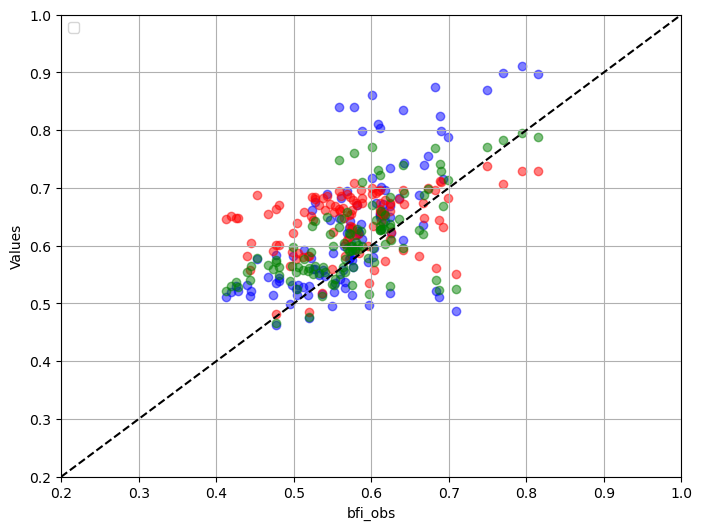

In [155]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(nse_results_cal_r_1_100_rd["bfi_obs"], nse_results_cal_r_1_100_rd["bfi_sim"], color='blue', alpha=0.5)
plt.scatter(nse_results_cal_r_1_100_wd["bfi_obs"], nse_results_cal_r_1_100_wd["bfi_sim"], color='red', alpha=0.5)
plt.scatter(nse_results_cal_r_1_100["bfi_obs"], nse_results_cal_r_1_100["bfi_sim"], color='green', alpha=0.5)



# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [159]:
nse_results_cal_r_1_100_wd[nse_results_cal_r_1_100_wd.nse > 0.85]

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
8,BundespegelTrierUp,DEBU1958,0.856537,0.926721,0.883486,0.623734,0.671423,0.873145
74,La Moselle Ã Custines,FR003265,0.850350,1.229640,1.160500,0.614570,0.652153,0.881989


In [162]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.nse > 0.85]

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
6,BundespegelPerl,DEBU1956,0.850008,0.952513,0.975579,0.610835,0.627549,0.878422
7,BundespegelFremersdorf,DEBU1957,0.863898,0.772392,0.757502,0.605700,0.644697,0.849868
8,BundespegelTrierUp,DEBU1958,0.890779,0.926721,0.894509,0.623734,0.632946,0.908704
9,BundespegelCochem,DEBU1959,0.865428,0.884826,0.873316,0.611554,0.633754,0.905794
10,Bollendorf,DERP2003,0.850318,0.920559,0.884371,0.574428,0.592814,0.860745
41,A5500610,FR000140,0.860259,1.443957,1.466437,0.568520,0.596272,NaN
54,A9251050,FR000190,0.872400,0.760271,0.783462,0.635066,0.646806,NaN
63,La Moselle Ã Toul,FR003249,0.869289,1.477275,1.386873,0.583065,0.600707,NaN
74,La Moselle Ã Custines,FR003265,0.875261,1.229640,1.150327,0.614570,0.638989,0.908044
84,La Moselle Ã Uckange,FR003284,0.859676,0.976771,1.004625,0.611175,0.627148,NaN


In [163]:
nse_results_cal_r_1_100_rd[nse_results_cal_r_1_100_rd.nse > 0.85]

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Reuland,BEWA0066,0.859969,1.224479,1.287726,0.511429,0.527890,0.870149
6,BundespegelPerl,DEBU1956,0.873249,0.952513,1.019302,0.610835,0.652430,0.880238
7,BundespegelFremersdorf,DEBU1957,0.872191,0.772392,0.758319,0.605700,0.672921,0.864478
8,BundespegelTrierUp,DEBU1958,0.913050,0.926721,0.932549,0.623734,0.650301,0.937118
9,BundespegelCochem,DEBU1959,0.891234,0.884826,0.908834,0.611554,0.650067,0.918659
10,Bollendorf,DERP2003,0.854783,0.920559,0.962504,0.574428,0.575705,0.812814
22,Hentern,DERP2017,0.873659,1.184664,1.046509,0.625278,0.622249,0.877013
23,Kasel,DERP2018,0.876086,0.942369,1.037128,0.578204,0.594691,0.889127
24,Juenkerath,DERP2021,0.851887,1.266179,1.168737,0.481239,0.538415,0.882975
32,DhronTalsperre,DERP2031,0.867637,1.023733,1.023428,0.595343,0.571508,0.905362


In [164]:
nse_results_cal_r_1_100_rd[nse_results_cal_r_1_100_rd.nse < 0.50]

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
2,Martelange,BEWA0087,-24.197576,0.192824,1.344930,0.708779,0.486090,NaN
18,Contwig,DERP2013,0.373181,0.645713,0.726958,0.814322,0.896768,-0.473032
29,Eisenschmitt,DERP2028,0.485746,0.932864,0.837345,0.600504,0.860036,0.159833
43,A6232010,FR000144,0.025046,1.326263,1.229793,0.681845,0.873768,NaN
50,A8122000,FR000174,0.481142,0.498502,0.576700,0.412715,0.511080,NaN
53,A9021050,FR000185,0.084401,0.758821,1.151332,0.558059,0.839959,NaN
64,La Meurthe Ã Fraize,FR003250,0.157543,2.136579,1.598438,0.683473,0.520538,NaN
71,L'ArentÃƒÂ¨le ÃƒÂ Saint-Gorgon et ÃƒÂ Sainte...,FR003259,0.178427,0.817462,1.186523,0.587749,0.798194,NaN
82,Le Woigot Ã Briey,FR003280,0.351564,1.276007,0.836650,0.687017,0.510110,NaN
85,Le Canner Ã KÅ“nigsmacker,FR003288,0.437284,0.485706,0.573288,0.586159,0.637650,NaN


In [24]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


In [231]:
nse_results_cal_g_1_100_rd.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.667365
DERP2017    0.674383
DERP2011    0.756394
DERP2013    0.223553
DERP2007    0.821042
DERP2024    0.820934
FR003253    0.790201
FR003283    0.819157
FR003301    0.821218
DERP2003    0.742850
FR003265    0.883851
FR003272    0.864318
DEBU1958    0.902258
Name: nse, dtype: float64

In [166]:
nse_results_cal_r_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.686314
DERP2017    0.819601
DERP2011    0.760643
DERP2013   -0.021018
DERP2007    0.784394
DERP2024    0.822409
FR003253    0.757550
FR003283    0.760648
FR003301    0.803412
DERP2003    0.850318
FR003265    0.875261
FR003272    0.844946
DEBU1958    0.890779
Name: nse, dtype: float64

In [221]:
kge_results_cal_r_1_100.set_index("basin", inplace=False).loc[list_cal].kge.mean()

0.6866792728626309

In [167]:
nse_results_cal_r_1_100_wd.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.618571
DERP2017    0.817391
DERP2011    0.691721
DERP2013    0.013643
DERP2007    0.761637
DERP2024    0.806348
FR003253    0.720001
FR003283    0.695391
FR003301    0.725248
DERP2003    0.819663
FR003265    0.850350
FR003272    0.816596
DEBU1958    0.856537
Name: nse, dtype: float64

In [220]:
kge_results_cal_r_1_100_wd.set_index("basin", inplace=False).loc[list_cal].kge.mean()

0.6315595131499556

In [219]:
nse_results_cal_r_1_100_rd.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.518116
DERP2017    0.873659
DERP2011    0.766914
DERP2013    0.373181
DERP2007    0.817717
DERP2024    0.839111
FR003253    0.742590
FR003283    0.786854
FR003301    0.835254
DERP2003    0.854783
FR003265    0.880426
FR003272    0.860205
DEBU1958    0.913050
Name: nse, dtype: float64

In [218]:
kge_results_cal_r_1_100_rd.set_index("basin", inplace=False).loc[list_cal].kge.mean()

0.7470356753879506

In [170]:
data_diff_cal14 = pd.DataFrame(data=nse_results_cal_r_1_100_rd.nse - nse_results_cal_r_1_100.nse)
data_diff_cal14["nse_rwd"] = nse_results_cal_r_1_100_wd.nse - nse_results_cal_r_1_100.nse

data_diff_cal14.index = nse_results_cal_r_1_100.basin

data_diff_cal14 = data_diff_cal14.loc[data_diff_cal14.index.isin(list_cal)]

data_diff_cal14["nse_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse
data_diff_cal14["nse_rd1"] = nse_results_cal_r_1_100_rd.set_index("basin", inplace = False).nse
data_diff_cal14["nse_wd1"] = nse_results_cal_r_1_100_wd.set_index("basin", inplace = False).nse

data_diff_cal14["nse_bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal14["nse_bfi_rd1"] = nse_results_cal_r_1_100_rd.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal14["nse_bfi_wd1"] = nse_results_cal_r_1_100_wd.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal14["bfi_obs"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_cal14["bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_cal14["bfi_rd1"] = nse_results_cal_r_1_100_rd.set_index("basin", inplace = False).bfi_sim
data_diff_cal14["bfi_wd1"] = nse_results_cal_r_1_100_wd.set_index("basin", inplace = False).bfi_sim

data_diff_cal14 = data_diff_cal14[data_diff_cal14.nse_r1 > -10.0]
data_diff_cal14

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,bfi_rd1,bfi_wd1
basin,,,,,,,,,,,,
DEBU1958,0.022271,-0.034243,0.890779,0.913050,0.856537,0.908704,0.937118,0.873145,0.623734,0.632946,0.650301,0.671423
DERP2003,0.004465,-0.030655,0.850318,0.854783,0.819663,0.860745,0.812814,0.834876,0.574428,0.592814,0.575705,0.628378
DERP2007,0.033323,-0.022757,0.784394,0.817717,0.761637,0.862921,0.882782,0.806527,0.498372,0.597256,0.582097,0.621113
DERP2011,0.006271,-0.068922,0.760643,0.766914,0.691721,0.650019,0.573303,0.440387,0.557702,0.632648,0.647482,0.662964
DERP2013,0.394199,0.034661,-0.021018,0.373181,0.013643,-1.207482,-0.473032,-1.271984,0.814322,0.787752,0.896768,0.729618
DERP2017,0.054058,-0.002209,0.819601,0.873659,0.817391,0.768986,0.877013,0.784607,0.625278,0.610490,0.622249,0.623198
DERP2024,0.016702,-0.016062,0.822409,0.839111,0.806348,0.765945,0.788523,0.761808,0.612685,0.628038,0.628924,0.641756
FR000184,-0.168198,-0.067742,0.686314,0.518116,0.618571,NaN,NaN,NaN,0.769605,0.783596,0.898412,0.706789
FR003253,-0.014960,-0.037550,0.757550,0.742590,0.720001,NaN,NaN,NaN,0.668338,0.687341,0.740261,0.647063


In [171]:
data_diff_cal14.corr()["bfi_obs"].iloc[-4:]

bfi_obs    1.000000
bfi_r1     0.908536
bfi_rd1    0.920508
bfi_wd1    0.758361
Name: bfi_obs, dtype: float64

(0.2, 1.0)

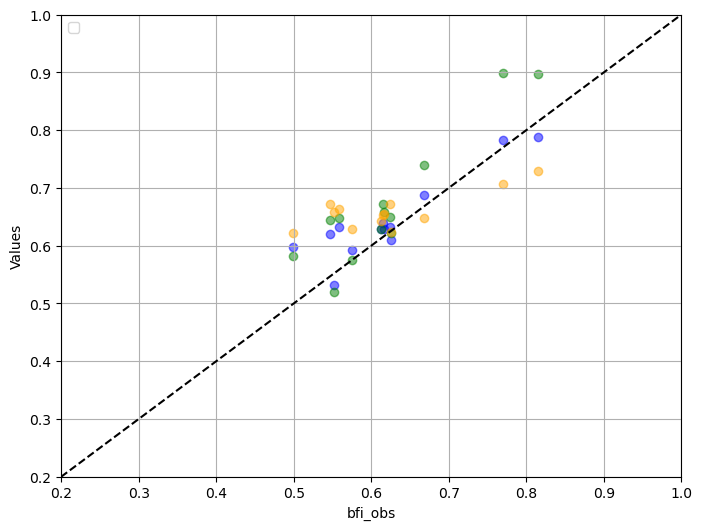

In [172]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_diff_cal14["bfi_obs"], data_diff_cal14["bfi_r1"], color='blue', alpha=0.5)
plt.scatter(data_diff_cal14["bfi_obs"], data_diff_cal14["bfi_rd1"], color='green', alpha=0.5)
plt.scatter(data_diff_cal14["bfi_obs"], data_diff_cal14["bfi_wd1"], color='orange',alpha=0.5)


# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [25]:
data_diff_cal = pd.DataFrame(data=nse_results_cal_r_1_100_rd.nse - nse_results_cal_r_1_100.nse)
data_diff_cal["nse_rwd"] = nse_results_cal_r_1_100_wd.nse - nse_results_cal_r_1_100.nse

data_diff_cal.index = nse_results_cal_r_1_100.basin

data_diff_cal = data_diff_cal.loc[~data_diff_cal.index.isin(list_cal)]

data_diff_cal["nse_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse
data_diff_cal["nse_rd1"] = nse_results_cal_r_1_100_rd.set_index("basin", inplace = False).nse
data_diff_cal["nse_wd1"] = nse_results_cal_r_1_100_wd.set_index("basin", inplace = False).nse
#data_diff_cal["nse_grd1"] = nse_results_cal_g_1_100_rd.set_index("basin", inplace = False).nse

data_diff_cal["nse_bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal["nse_bfi_rd1"] = nse_results_cal_r_1_100_rd.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal["nse_bfi_wd1"] = nse_results_cal_r_1_100_wd.set_index("basin", inplace = False).nse_value_bfi
#data_diff_cal["nse_bfi_grd1"] = nse_results_cal_g_1_100_rd.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal["bfi_obs"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_cal["bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_cal["bfi_rd1"] = nse_results_cal_r_1_100_rd.set_index("basin", inplace = False).bfi_sim
data_diff_cal["bfi_wd1"] = nse_results_cal_r_1_100_wd.set_index("basin", inplace = False).bfi_sim
#data_diff_cal["bfi_grd1"] = nse_results_cal_g_1_100_rd.set_index("basin", inplace = False).bfi_sim

data_diff_cal = data_diff_cal[data_diff_cal.nse_r1 > -10.0]
data_diff_cal

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,bfi_rd1,bfi_wd1
basin,,,,,,,,,,,,
BEWA0066,0.033567,-0.023901,0.826402,0.859969,0.802501,0.823303,0.870149,0.738513,0.511429,0.557320,0.527890,0.579886
BEWA0067,0.062397,-0.011242,0.776418,0.838815,0.765176,0.765821,0.841366,0.668949,0.443161,0.540013,0.512718,0.557846
BEWA0106,0.056349,-0.042718,0.738859,0.795208,0.696140,NaN,NaN,NaN,0.473400,0.560178,0.514694,0.590243
BEWA0107,-0.066692,-0.048186,0.723577,0.656885,0.675391,NaN,NaN,NaN,0.565604,0.553497,0.526716,0.582488
BEWA0119,0.029605,-0.021654,0.811971,0.841577,0.790317,NaN,NaN,NaN,0.503286,0.554247,0.524335,0.576483
...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,0.018524,-0.035530,0.753774,0.772298,0.718244,0.778332,0.813118,0.687294,0.517760,0.555506,0.514793,0.581931
LU000016,-0.134999,-0.090622,0.688915,0.553916,0.598293,0.497113,-0.068211,0.613615,0.563590,0.562215,0.558435,0.665154
LU000017,0.012361,-0.030186,0.852524,0.864885,0.822338,0.871139,0.849509,0.846492,0.574924,0.598715,0.584494,0.632822


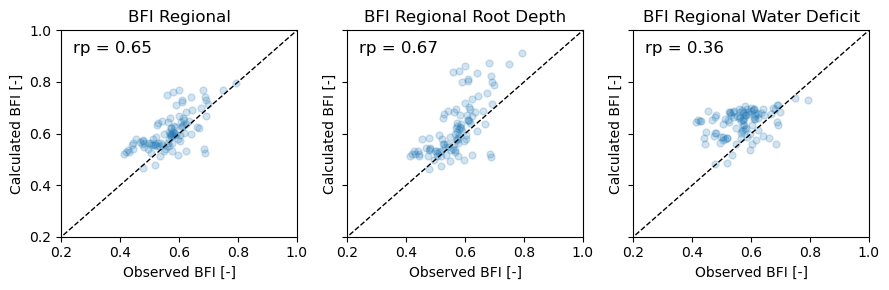

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_rd1', 'bfi_wd1']
titles = ['BFI Regional', 'BFI Regional Root Depth', 'BFI Regional Water Deficit']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_cal["bfi_obs"]
    y = data_diff_cal[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_cal[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

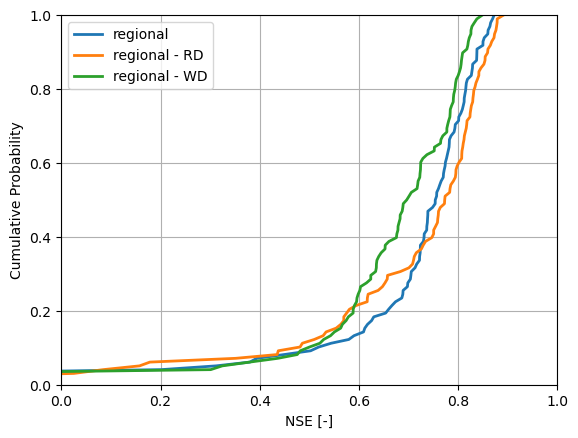

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal["nse_rd1"].dropna())
nse_values_3 = np.sort(data_diff_cal["nse_wd1"].dropna())
#nse_values_4 = np.sort(data_diff_cal["nse_grd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)
#cumulative_4 = np.arange(1, len(nse_values_4) + 1) / len(nse_values_4)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="regional - RD", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="regional - WD", linewidth=2)
#plt.plot(nse_values_4, cumulative_3, label="global - RD", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


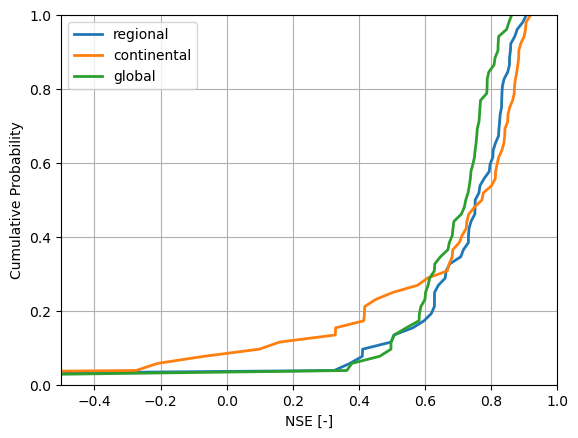

In [175]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal["nse_bfi_rd1"].dropna())
nse_values_3 = np.sort(data_diff_cal["nse_bfi_wd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.5, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


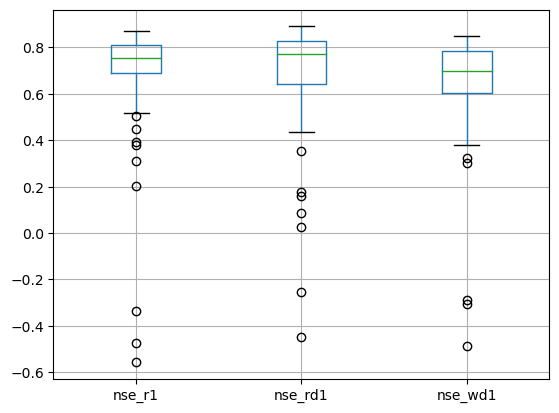

In [28]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal[data_diff_cal.nse_wd1 > -6].boxplot(column=["nse_r1","nse_rd1", "nse_wd1"])

# Show the plot
plt.show()


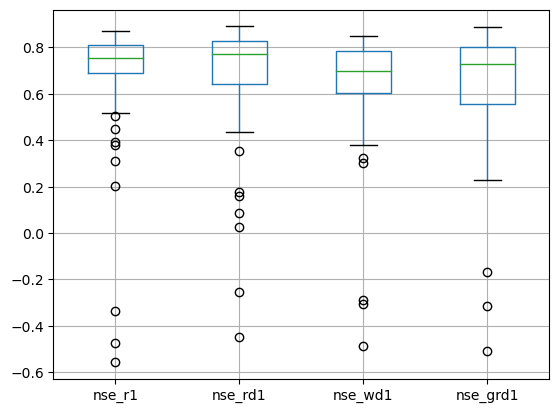

In [235]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal[data_diff_cal.nse_wd1 > -6].boxplot(column=["nse_r1","nse_rd1", "nse_wd1", "nse_grd1"])

# Show the plot
plt.show()


In [177]:
data_diff_cal[data_diff_cal.nse_r1 > 0.8].iloc[:, 0:-3]

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs
basin,,,,,,,,,
BEWA0066,0.033567,-0.023901,0.826402,0.859969,0.802501,0.823303,0.870149,0.738513,0.511429
BEWA0119,0.029605,-0.021654,0.811971,0.841577,0.790317,NaN,NaN,NaN,0.503286
DEBU1956,0.023241,-0.030639,0.850008,0.873249,0.819369,0.878422,0.880238,0.820871,0.610835
DEBU1957,0.008293,-0.072844,0.863898,0.872191,0.791054,0.849868,0.864478,0.808367,0.605700
DEBU1959,0.025806,-0.032887,0.865428,0.891234,0.832541,0.905794,0.918659,0.853411,0.611554
DERP2004,0.011678,-0.030830,0.814905,0.826583,0.784075,0.831013,0.838172,0.718631,0.504991
DERP2018,0.026242,-0.043240,0.849845,0.876086,0.806605,0.857983,0.889127,0.757619,0.578204
DERP2030,0.029541,-0.039288,0.816389,0.845930,0.777101,0.826816,0.903385,0.736789,0.602398
DERP2031,0.030550,-0.019532,0.837087,0.867637,0.817556,0.832286,0.905362,0.792580,0.595343


In [193]:
data_diff_cal[data_diff_cal.nse_rd1 > 0.85]

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,bfi_rd1,bfi_wd1
basin,,,,,,,,,,,,
BEWA0066,0.033567,-0.023901,0.826402,0.859969,0.802501,0.823303,0.870149,0.738513,0.511429,0.557320,0.527890,0.579886
DEBU1956,0.023241,-0.030639,0.850008,0.873249,0.819369,0.878422,0.880238,0.820871,0.610835,0.627549,0.652430,0.662566
DEBU1957,0.008293,-0.072844,0.863898,0.872191,0.791054,0.849868,0.864478,0.808367,0.605700,0.644697,0.672921,0.691761
DEBU1959,0.025806,-0.032887,0.865428,0.891234,0.832541,0.905794,0.918659,0.853411,0.611554,0.633754,0.650067,0.673029
DERP2018,0.026242,-0.043240,0.849845,0.876086,0.806605,0.857983,0.889127,0.757619,0.578204,0.593044,0.594691,0.618467
DERP2021,0.060229,-0.014508,0.791658,0.851887,0.777151,0.812650,0.882975,0.751125,0.481239,0.563341,0.538415,0.600447
DERP2031,0.030550,-0.019532,0.837087,0.867637,0.817556,0.832286,0.905362,0.792580,0.595343,0.577738,0.571508,0.599648
FR000140,-0.005847,-0.022647,0.860259,0.854412,0.837612,NaN,NaN,NaN,0.568520,0.596272,0.622218,0.609250
FR000190,0.006231,-0.046820,0.872400,0.878631,0.825580,NaN,NaN,NaN,0.635066,0.646806,0.681926,0.681043


<Axes: >

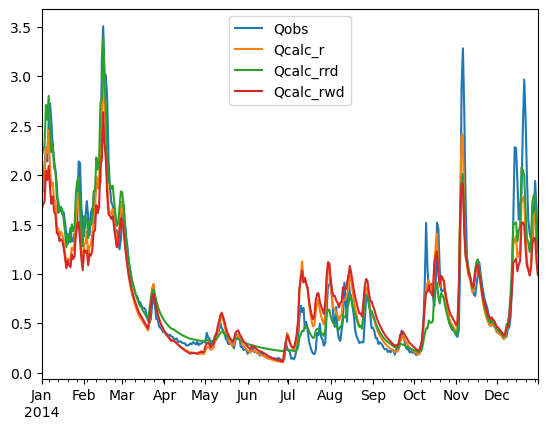

In [236]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

gauge_id="DEBU1959"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

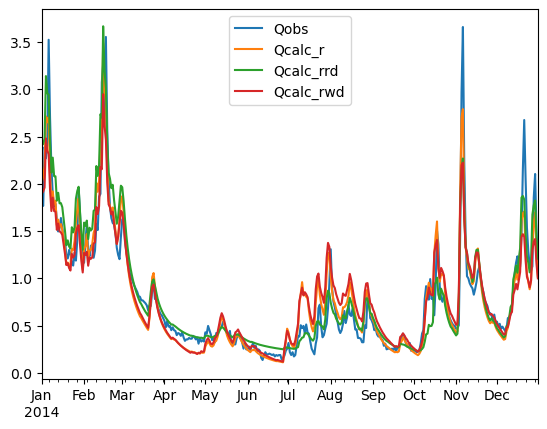

In [192]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

gauge_id="DEBU1956"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

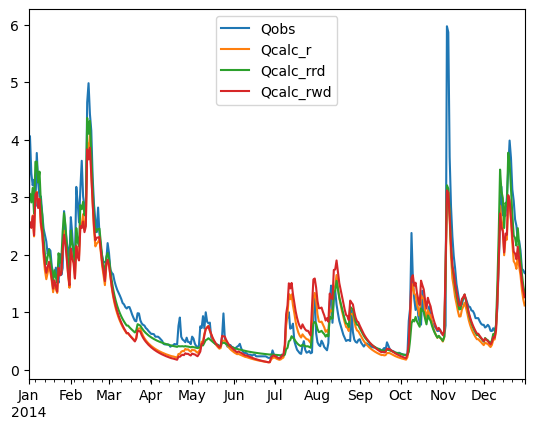

In [178]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

gauge_id="DERP2017"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

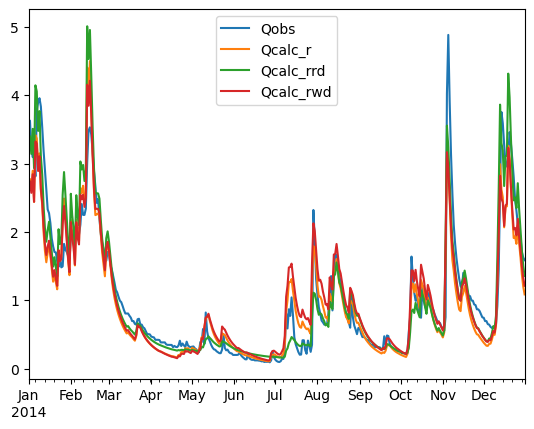

In [179]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

gauge_id="DERP2031"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd[gauge_id][0]


1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

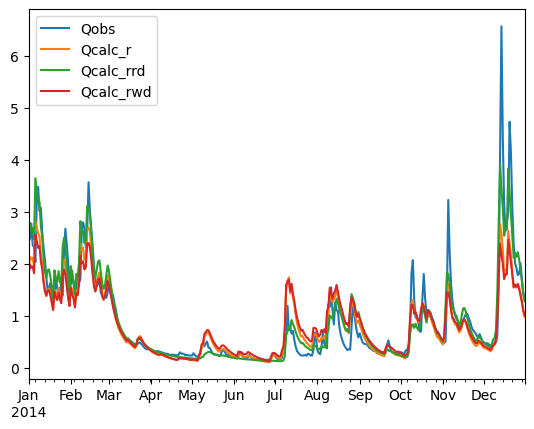

In [180]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))


gauge_id="LU000017"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd[gauge_id][0]


1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

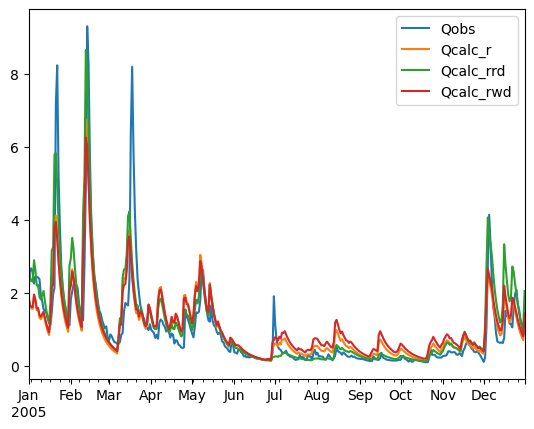

In [210]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))


gauge_id="LU000019"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd[gauge_id][0]


1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005"].plot()

In [209]:
Qtimeseries.corr()

,Qobs,Qcalc_r,Qcalc_rrd,Qcalc_rwd
Qobs,1.000000,0.857272,0.866846,0.857817
Qcalc_r,0.857272,1.000000,0.978044,0.996708
Qcalc_rrd,0.866846,0.978044,1.000000,0.976374
Qcalc_rwd,0.857817,0.996708,0.976374,1.000000


In [170]:
data_diff_cal[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]] = estreams_attributes[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]]
data_diff_cal[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]] = estreams_attributes[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]]
data_diff_cal[['lat_snap', 'lon_snap']] = estreams_attributes[['lat_snap', 'lon_snap']]
data_diff_cal[['area']] = estreams_attributes[['area_estreams']]

data_diff_cal

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,bfi_g1,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,lat_snap,lon_snap,area
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.034058,0.310443,0.826402,0.860460,0.515958,0.823303,0.883596,0.138918,0.511429,0.557320,...,0.803718,3.0,3.0,94.0,75.0,25.0,0.0,50.188258,6.151802,357.829
BEWA0067,-0.019116,0.267704,0.776418,0.795534,0.508714,0.765821,0.795083,0.047242,0.443161,0.540013,...,0.760583,2.0,0.0,98.0,64.0,36.0,0.0,50.289277,6.263467,101.033
BEWA0106,-0.047748,0.465526,0.738859,0.786607,0.273333,NaN,NaN,NaN,0.473400,0.560178,...,0.846723,0.0,0.0,100.0,100.0,0.0,0.0,50.196522,6.150669,58.549
BEWA0107,-0.038995,0.380173,0.723577,0.762572,0.343404,NaN,NaN,NaN,0.565604,0.553497,...,0.832013,4.0,15.0,81.0,100.0,0.0,0.0,50.235014,6.153292,77.098
BEWA0119,-0.027736,0.313667,0.811971,0.839707,0.498304,NaN,NaN,NaN,0.503286,0.554247,...,0.793015,3.0,3.0,94.0,75.0,25.0,0.0,50.141935,6.141814,395.486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,-0.078411,0.401203,0.753774,0.832185,0.352571,0.778332,0.853968,-0.200624,0.517760,0.555506,...,0.846011,2.0,0.0,98.0,100.0,0.0,0.0,49.895421,6.091178,946.519
LU000016,0.114346,0.128390,0.688915,0.574570,0.560526,0.497113,0.071846,-0.166926,0.563590,0.562215,...,0.552001,14.0,86.0,0.0,0.0,100.0,0.0,49.620647,6.132266,387.289
LU000017,0.003912,0.101954,0.852524,0.848612,0.750569,0.871139,0.857222,0.680423,0.574924,0.598715,...,0.727089,19.0,31.0,50.0,41.0,59.0,0.0,49.785883,6.509851,4255.524


In [171]:
data_diff_cal[data_diff_cal.nse_r1<0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,bfi_g1,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,lat_snap,lon_snap,area
basin,,,,,,,,,,,,,,,,,,,,,
FR000144,-0.161702,-0.107624,-0.338022,-0.176320,-0.230398,NaN,NaN,NaN,0.681845,0.768781,...,0.804764,92.0,0.0,8.0,83.0,5.0,12.0,48.416320,6.877879,117.784
FR000185,0.175389,0.078666,0.380050,0.204661,0.301385,NaN,NaN,NaN,0.558059,0.747527,...,0.790320,75.0,23.0,2.0,71.0,27.0,2.0,48.680322,7.014472,188.492
FR003250,-0.062410,-0.089830,0.201436,0.263847,0.291266,NaN,NaN,NaN,0.683473,0.540899,...,0.585286,4.0,0.0,96.0,0.0,6.0,94.0,48.184730,7.002529,67.143
FR003259,0.141190,0.013033,0.311947,0.170757,0.298914,NaN,NaN,NaN,0.587749,0.710226,...,0.670856,66.0,34.0,0.0,35.0,65.0,0.0,48.324169,6.645964,64.746
FR003280,-0.054395,-0.049826,0.393840,0.448235,0.443666,NaN,NaN,NaN,0.687017,0.523113,...,0.550688,0.0,100.0,0.0,0.0,100.0,0.0,49.246953,5.933378,74.738
FR003288,0.042357,0.177624,0.448982,0.406625,0.271358,NaN,NaN,NaN,0.586159,0.624539,...,0.550658,29.0,71.0,0.0,0.0,100.0,0.0,49.391885,6.272360,108.785
FR003303,-0.045123,-0.015703,-0.557843,-0.512720,-0.542140,-2.193359,-2.774296,-2.535956,0.794509,0.795206,...,0.845255,98.0,2.0,0.0,96.0,4.0,0.0,49.127103,7.472093,95.212
FR003306,-0.262914,-0.075006,-0.472334,-0.209420,-0.397328,NaN,NaN,NaN,0.749280,0.769845,...,0.809703,94.0,6.0,0.0,91.0,9.0,0.0,49.225799,6.688894,58.148


In [172]:
data_diff_cal[data_diff_cal.nse_g1<0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,bfi_g1,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,lat_snap,lon_snap,area
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0106,-0.047748,0.465526,0.738859,0.786607,0.273333,NaN,NaN,NaN,0.473400,0.560178,...,0.846723,0.0,0.0,100.0,100.0,0.0,0.0,50.196522,6.150669,58.549
BEWA0107,-0.038995,0.380173,0.723577,0.762572,0.343404,NaN,NaN,NaN,0.565604,0.553497,...,0.832013,4.0,15.0,81.0,100.0,0.0,0.0,50.235014,6.153292,77.098
BEWA0119,-0.027736,0.313667,0.811971,0.839707,0.498304,NaN,NaN,NaN,0.503286,0.554247,...,0.793015,3.0,3.0,94.0,75.0,25.0,0.0,50.141935,6.141814,395.486
FR000144,-0.161702,-0.107624,-0.338022,-0.176320,-0.230398,NaN,NaN,NaN,0.681845,0.768781,...,0.804764,92.0,0.0,8.0,83.0,5.0,12.0,48.416320,6.877879,117.784
FR000174,0.058445,0.043990,0.543822,0.485377,0.499832,NaN,NaN,NaN,0.412715,0.520488,...,0.548412,0.0,100.0,0.0,1.0,99.0,0.0,49.098776,5.837081,132.249
FR000185,0.175389,0.078666,0.380050,0.204661,0.301385,NaN,NaN,NaN,0.558059,0.747527,...,0.790320,75.0,23.0,2.0,71.0,27.0,2.0,48.680322,7.014472,188.492
FR003250,-0.062410,-0.089830,0.201436,0.263847,0.291266,NaN,NaN,NaN,0.683473,0.540899,...,0.585286,4.0,0.0,96.0,0.0,6.0,94.0,48.184730,7.002529,67.143
FR003259,0.141190,0.013033,0.311947,0.170757,0.298914,NaN,NaN,NaN,0.587749,0.710226,...,0.670856,66.0,34.0,0.0,35.0,65.0,0.0,48.324169,6.645964,64.746
FR003280,-0.054395,-0.049826,0.393840,0.448235,0.443666,NaN,NaN,NaN,0.687017,0.523113,...,0.550688,0.0,100.0,0.0,0.0,100.0,0.0,49.246953,5.933378,74.738


In [173]:
data_diff_cal.corr()

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,bfi_g1,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,lat_snap,lon_snap,area
nse,1.000000,0.010238,0.201719,-0.173474,0.195446,-0.115490,-0.475158,-0.128136,0.030386,0.334681,...,-0.133968,0.286823,0.184957,-0.360484,-0.174870,0.285378,-0.223633,0.031748,0.079077,-0.083223
nse_rg,0.010238,1.000000,0.242853,0.240339,-0.263193,0.136068,0.175018,-0.415036,-0.280035,-0.179718,...,0.538962,-0.283654,-0.272276,0.440365,0.573869,-0.345169,-0.349138,0.588110,-0.353708,-0.111144
nse_r1,0.201719,0.242853,1.000000,0.929601,0.871945,0.976431,0.894321,0.763905,-0.410996,-0.380854,...,-0.136763,-0.478424,0.100854,0.217116,-0.185111,0.180250,-0.013585,0.173296,-0.198658,0.198964
nse_c1,-0.173474,0.240339,0.929601,1.000000,0.803200,0.903739,0.978582,0.722465,-0.424694,-0.508893,...,-0.087104,-0.588992,0.031809,0.353963,-0.120326,0.073854,0.070494,0.162304,-0.229509,0.231377
nse_g1,0.195446,-0.263193,0.871945,0.803200,1.000000,0.807603,0.711279,0.925834,-0.267404,-0.288059,...,-0.408036,-0.332637,0.237723,-0.006334,-0.473736,0.353473,0.162704,-0.124482,-0.019047,0.253969
nse_bfi_r1,-0.115490,0.136068,0.976431,0.903739,0.807603,1.000000,0.911266,0.793382,-0.512003,-0.501538,...,-0.123628,-0.571420,0.037422,0.307283,-0.154993,0.115827,0.124338,0.135433,-0.300159,0.146371
nse_bfi_c1,-0.475158,0.175018,0.894321,0.978582,0.711279,0.911266,1.000000,0.733817,-0.510394,-0.573303,...,-0.026782,-0.639918,-0.093089,0.453713,-0.054671,0.005850,0.159222,0.140643,-0.238268,0.164519
nse_bfi_g1,-0.128136,-0.415036,0.763905,0.722465,0.925834,0.793382,0.733817,1.000000,-0.250108,-0.226065,...,-0.266103,-0.314109,0.143742,0.068919,-0.342578,0.253772,0.282197,-0.111760,0.082287,0.216870
bfi_obs,0.030386,-0.280035,-0.410996,-0.424694,-0.267404,-0.512003,-0.510394,-0.250108,1.000000,0.651260,...,0.333839,0.700842,-0.203832,-0.265412,0.313916,-0.358580,0.119936,-0.288938,0.450806,0.127213
bfi_r1,0.334681,-0.179718,-0.380854,-0.508893,-0.288059,-0.501538,-0.573303,-0.226065,0.651260,1.000000,...,0.481614,0.943624,-0.169143,-0.456174,0.414800,-0.244094,-0.262249,-0.112010,0.499743,0.081608


In [29]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_1988_2001'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'\\perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()


output_continental_2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1, perm_areas = perm_areascontinental)
output_regional_2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas = perm_areas)
output_global_2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1, perm_areas = perm_areasglobal)

nse_results_val_r_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_regional_2)
nse_results_val_c_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_continental_2)
nse_results_val_g_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_global_2)

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_7804\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_7804\2733552632.py:450: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\mi

In [30]:
data_diff_val = pd.DataFrame(data=nse_results_val_r_1_100.nse - nse_results_val_c_1_100.nse)
data_diff_val["nse_rg"] = nse_results_val_r_1_100.nse - nse_results_val_g_1_100.nse

data_diff_val.index = nse_results_val_c_1_100.basin

data_diff_val = data_diff_val.loc[~data_diff_val.index.isin(list_cal)]

data_diff_val["nse_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse
data_diff_val["nse_c1"] = nse_results_val_c_1_100.set_index("basin", inplace = False).nse
data_diff_val["nse_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).nse

data_diff_val["nse_bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_c1"] = nse_results_val_c_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).nse_value_bfi

data_diff_val["bfi_obs"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_val["bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_c1"] = nse_results_val_c_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).bfi_sim

data_diff_val = data_diff_val[data_diff_val.nse_r1 > -10.0]
data_diff_val

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,bfi_c1,bfi_g1
basin,,,,,,,,,,,,
BEWA0066,-0.027887,0.292720,0.818833,0.846719,0.526113,NaN,NaN,NaN,0.524659,0.552303,0.566561,0.786703
BEWA0067,-0.030009,0.270157,0.786773,0.816782,0.516617,NaN,NaN,NaN,0.469727,0.547326,0.563061,0.737641
BEWA0106,-0.062011,0.345959,0.718509,0.780521,0.372550,NaN,NaN,NaN,0.506445,0.539109,0.560652,0.821925
BEWA0107,-0.013761,0.226957,0.719498,0.733259,0.492541,NaN,NaN,NaN,0.557155,0.522635,0.533596,0.772290
BEWA0119,-0.027527,0.272161,0.784596,0.812124,0.512435,NaN,NaN,NaN,0.513078,0.538153,0.553451,0.757345
...,...,...,...,...,...,...,...,...,...,...,...,...
FR003300,0.044509,0.048603,0.505983,0.461474,0.457380,0.101674,0.030655,-0.036429,0.526066,0.651515,0.649514,0.674813
FR003302,0.052544,0.049895,0.789622,0.737078,0.739727,NaN,NaN,NaN,0.525576,0.595702,0.633415,0.620531
FR003303,-0.253899,-0.114652,-0.586202,-0.332303,-0.471551,NaN,NaN,NaN,0.804400,0.764694,0.866724,0.816654


<Axes: xlabel='basin'>

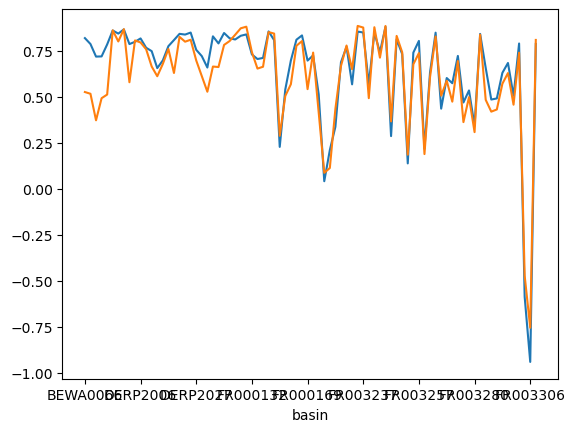

In [176]:
data_diff_val.nse_r1.plot()
data_diff_val.nse_g1.plot()

(0.2, 1.0)

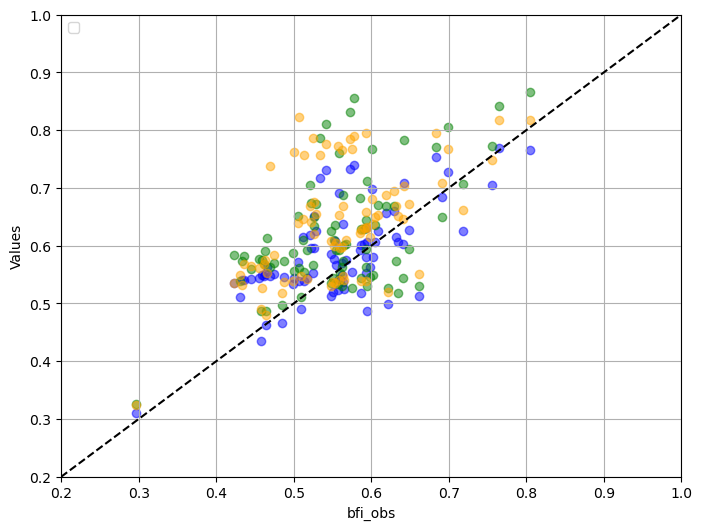

In [177]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_r1"], color='blue', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_c1"], color='green', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_g1"], color='orange',alpha=0.5)


# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])

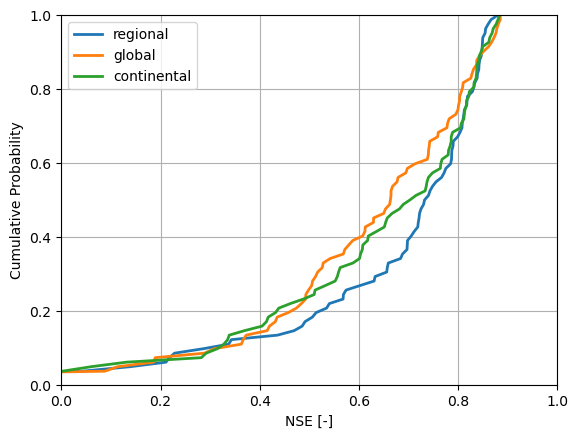

In [178]:


# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)


# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

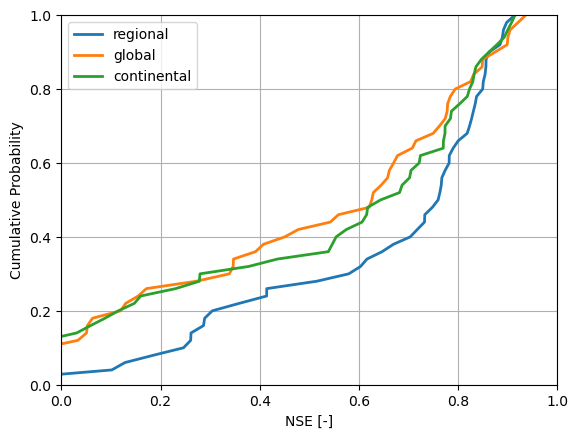

In [179]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)


# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [32]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_1988_2001'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'\\perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()


output_regional_wd_val = run_model_superflexpy_wd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_WD_1, perm_areas = perm_areas, waterdeficit_mean = waterdeficit_mean)
output_regional_rd_val = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_RD_1, perm_areas = perm_areas, waterdeficit_mean = rootdepth_mean)
output_regional_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas = perm_areas)
#output_global_rd_val = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_RD_1, perm_areas = perm_areasglobal, waterdeficit_mean = rootdepth_mean)

In [33]:
nse_results_val_r_1_100_wd = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_regional_wd_val)
nse_results_val_r_1_100_rd = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_regional_rd_val)
nse_results_val_r_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_regional_val)
#nse_results_cal_g_1_100_rd = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_global_rd_val)

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_7804\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_7804\2733552632.py:450: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\mi

In [244]:
nse_results_val_r_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\521990233.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_100.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.179721,0.007369,-0.273303,0.052353,0.940026
q_mean_obs,0.179721,1.000000,0.916750,-0.030378,-0.257507,0.269699
q_mean_calc,0.007369,0.916750,1.000000,-0.042306,-0.244138,0.263379
bfi_obs,-0.273303,-0.030378,-0.042306,1.000000,0.667274,-0.441137
bfi_sim,0.052353,-0.257507,-0.244138,0.667274,1.000000,-0.470206
nse_value_bfi,0.940026,0.269699,0.263379,-0.441137,-0.470206,1.000000


In [243]:
nse_results_val_r_1_100_rd.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\3420530449.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_100_rd.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.179122,-0.020309,-0.248872,0.079519,0.897603
q_mean_obs,0.179122,1.000000,0.913201,-0.030378,-0.195888,0.348054
q_mean_calc,-0.020309,0.913201,1.000000,-0.044067,-0.188652,0.348453
bfi_obs,-0.248872,-0.030378,-0.044067,1.000000,0.668968,-0.362228
bfi_sim,0.079519,-0.195888,-0.188652,0.668968,1.000000,-0.470102
nse_value_bfi,0.897603,0.348054,0.348453,-0.362228,-0.470102,1.000000


In [242]:
nse_results_val_r_1_100_wd.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\3948472811.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_100_wd.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.181888,-0.001501,-0.266865,0.109196,0.924621
q_mean_obs,0.181888,1.000000,0.909987,-0.030378,-0.656691,0.301352
q_mean_calc,-0.001501,0.909987,1.000000,-0.036929,-0.713737,0.280281
bfi_obs,-0.266865,-0.030378,-0.036929,1.000000,0.375799,-0.299670
bfi_sim,0.109196,-0.656691,-0.713737,0.375799,1.000000,-0.464909
nse_value_bfi,0.924621,0.301352,0.280281,-0.299670,-0.464909,1.000000


In [245]:
nse_results_val_r_1_100[nse_results_val_r_1_100.nse > 0.85]


,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
6,BundespegelPerl,DEBU1956,0.860349,1.079179,1.212445,0.586521,0.600863,0.889093
8,BundespegelTrierUp,DEBU1958,0.860558,0.979012,1.134230,0.593301,0.605634,0.848794
9,BundespegelCochem,DEBU1959,0.866199,1.038761,1.115567,0.604452,0.606576,0.897588
22,Hentern,DERP2017,0.870735,1.395562,1.288507,0.577916,0.586500,0.903583
41,A5500610,FR000140,0.855259,1.530514,1.749048,0.554309,0.567070,NaN
58,La Vologne Ã ChenimÃ©nil,FR003236,0.854176,2.306219,2.205165,0.601937,0.580139,0.884328
63,La Moselle Ã Toul,FR003249,0.879900,1.571429,1.659267,0.567660,0.575692,0.914033
74,La Moselle Ã Custines,FR003265,0.900127,1.422836,1.395776,0.591212,0.611798,0.934816


In [247]:
nse_results_val_r_1_100_wd[nse_results_val_r_1_100_wd.nse > 0.85]


,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
22,Hentern,DERP2017,0.858786,1.395562,1.327916,0.577916,0.597246,0.878294
63,La Moselle Ã Toul,FR003249,0.850662,1.571429,1.745111,0.567660,0.586512,0.854238
74,La Moselle Ã Custines,FR003265,0.882442,1.422836,1.459797,0.591212,0.615866,0.909752


In [248]:
nse_results_val_r_1_100_rd[nse_results_val_r_1_100_rd.nse > 0.85]


,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
6,BundespegelPerl,DEBU1956,0.867679,1.079179,1.255430,0.586521,0.623633,0.858107
7,BundespegelFremersdorf,DEBU1957,0.853403,0.876168,0.980890,0.608043,0.654052,0.731655
8,BundespegelTrierUp,DEBU1958,0.860260,0.979012,1.181399,0.593301,0.622321,0.811103
9,BundespegelCochem,DEBU1959,0.874909,1.038761,1.161963,0.604452,0.622478,0.888446
22,Hentern,DERP2017,0.892641,1.395562,1.368299,0.577916,0.600451,0.929865
24,Juenkerath,DERP2021,0.870837,1.453947,1.529250,0.462274,0.530819,0.878720
36,A4050620,FR000125,0.857180,3.826654,3.411589,0.484163,0.465563,0.878094
37,A4200630,FR000128,0.855743,3.216753,2.960241,0.509667,0.493914,0.893937
63,La Moselle Ã Toul,FR003249,0.874277,1.571429,1.743054,0.567660,0.600471,0.882059
74,La Moselle Ã Custines,FR003265,0.898678,1.422836,1.456246,0.591212,0.645551,0.912683


In [34]:
data_diff_val = pd.DataFrame(data=nse_results_val_r_1_100_rd.nse - nse_results_val_r_1_100.nse)
data_diff_val["nse_rwd"] = nse_results_val_r_1_100_wd.nse - nse_results_val_r_1_100.nse

data_diff_val.index = nse_results_val_r_1_100.basin

data_diff_val = data_diff_val.loc[~data_diff_val.index.isin(list_cal)]

data_diff_val["nse_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse
data_diff_val["nse_rd1"] = nse_results_val_r_1_100_rd.set_index("basin", inplace = False).nse
data_diff_val["nse_wd1"] = nse_results_val_r_1_100_wd.set_index("basin", inplace = False).nse

data_diff_val["nse_bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_rd1"] = nse_results_val_r_1_100_rd.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_wd1"] = nse_results_val_r_1_100_wd.set_index("basin", inplace = False).nse_value_bfi

data_diff_val["bfi_obs"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_val["bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_rd1"] = nse_results_val_r_1_100_rd.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_wd1"] = nse_results_val_r_1_100_wd.set_index("basin", inplace = False).bfi_sim

data_diff_val = data_diff_val[data_diff_val.nse_r1 > -10.0]
data_diff_val

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,bfi_rd1,bfi_wd1
basin,,,,,,,,,,,,
BEWA0066,-0.010863,-0.032709,0.818833,0.807970,0.786124,NaN,NaN,NaN,0.524659,0.552303,0.532573,0.566430
BEWA0067,0.044448,-0.002998,0.786773,0.831221,0.783776,NaN,NaN,NaN,0.469727,0.547326,0.532882,0.558599
BEWA0106,-0.008568,-0.042722,0.718509,0.709941,0.675787,NaN,NaN,NaN,0.506445,0.539109,0.507066,0.556166
BEWA0107,-0.120841,-0.044368,0.719498,0.598657,0.675130,NaN,NaN,NaN,0.557155,0.522635,0.506235,0.543420
BEWA0119,-0.017585,-0.027685,0.784596,0.767012,0.756911,NaN,NaN,NaN,0.513078,0.538153,0.517465,0.550190
...,...,...,...,...,...,...,...,...,...,...,...,...
FR003300,-0.005831,-0.037039,0.505983,0.500152,0.468944,0.101674,-0.071019,0.016227,0.526066,0.651515,0.691684,0.670978
FR003302,0.003531,-0.072840,0.789622,0.793154,0.716782,NaN,NaN,NaN,0.525576,0.595702,0.614696,0.651730
FR003303,0.312638,-0.115531,-0.586202,-0.273564,-0.701733,NaN,NaN,NaN,0.804400,0.764694,0.885353,0.678150


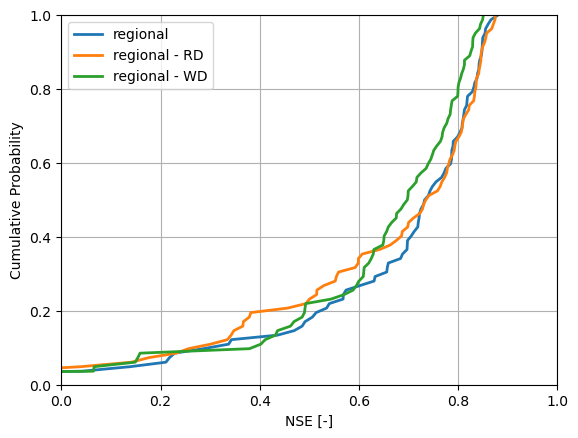

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_rd1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_wd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="regional - RD", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="regional - WD", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


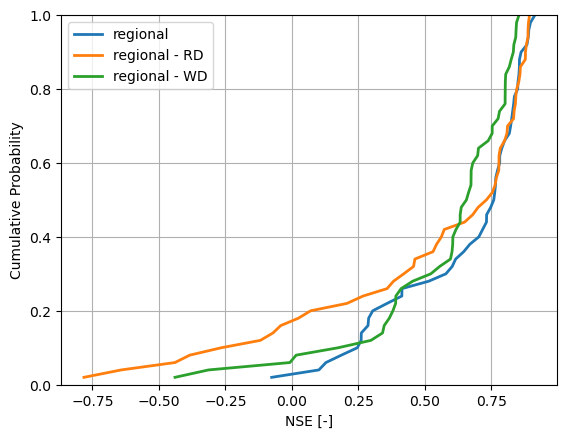

In [272]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_bfi_rd1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_bfi_wd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="regional - RD", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="regional - WD", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
#plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [268]:
data_diff_val[data_diff_val.nse_r1>0.85]

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,bfi_rd1,bfi_wd1
basin,,,,,,,,,,,,
DEBU1956,0.007330,-0.030404,0.860349,0.867679,0.829946,0.889093,0.858107,0.803002,0.586521,0.600863,0.623633,0.629518
DEBU1959,0.008710,-0.016963,0.866199,0.874909,0.849236,0.897588,0.888446,0.843388,0.604452,0.606576,0.622478,0.638333
FR000140,-0.019601,-0.042622,0.855259,0.835659,0.812637,NaN,NaN,NaN,0.554309,0.567070,0.593125,0.570887
FR003236,-0.020640,-0.028344,0.854176,0.833536,0.825832,0.884328,0.840934,0.833078,0.601937,0.580139,0.623398,0.539996
FR003249,-0.005623,-0.029238,0.879900,0.874277,0.850662,0.914033,0.882059,0.854238,0.567660,0.575692,0.600471,0.586512


In [43]:
data_diff_val["area"] = network_estreams["area_estreams"]

In [44]:
data_diff_val[data_diff_val.nse_rd1>0.7]

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,bfi_rd1,bfi_wd1,area
basin,,,,,,,,,,,,,
BEWA0066,-0.010863,-0.032709,0.818833,0.807970,0.786124,NaN,NaN,NaN,0.524659,0.552303,0.532573,0.566430,357.829
BEWA0067,0.044448,-0.002998,0.786773,0.831221,0.783776,NaN,NaN,NaN,0.469727,0.547326,0.532882,0.558599,101.033
BEWA0106,-0.008568,-0.042722,0.718509,0.709941,0.675787,NaN,NaN,NaN,0.506445,0.539109,0.507066,0.556166,58.549
BEWA0119,-0.017585,-0.027685,0.784596,0.767012,0.756911,NaN,NaN,NaN,0.513078,0.538153,0.517465,0.550190,395.486
DEBU1956,0.007330,-0.030404,0.860349,0.867679,0.829946,0.889093,0.858107,0.803002,0.586521,0.600863,0.623633,0.629518,11500.000
DEBU1957,0.010098,-0.032950,0.843304,0.853403,0.810354,0.732072,0.731655,0.674160,0.608043,0.624932,0.654052,0.661999,6970.000
DEBU1959,0.008710,-0.016963,0.866199,0.874909,0.849236,0.897588,0.888446,0.843388,0.604452,0.606576,0.622478,0.638333,27100.000
DERP2004,-0.009865,-0.047150,0.786498,0.776634,0.739349,0.763064,0.769311,0.633147,0.500469,0.543522,0.517331,0.559187,615.000
DERP2005,0.022471,-0.047987,0.798761,0.821233,0.750775,0.759450,0.809036,0.596642,0.444113,0.541454,0.505981,0.570428,125.000


<Axes: >

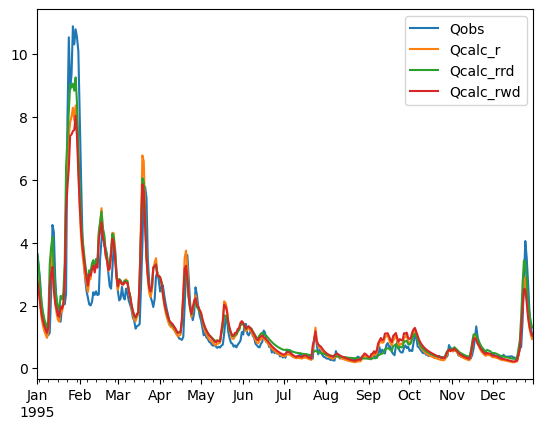

In [37]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="DEBU1959"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1995"].plot()

<Axes: >

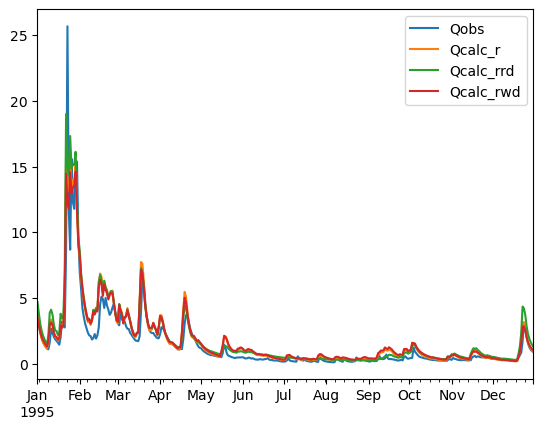

In [259]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="DERP2018"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1995"].plot()

<Axes: >

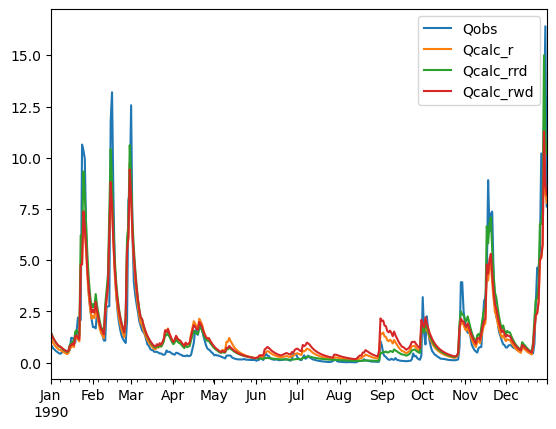

In [46]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="DERP2006"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1990"].plot()

<Axes: >

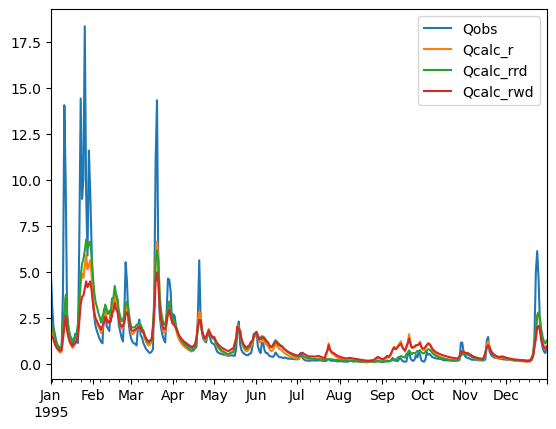

In [42]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="FR003246"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1995"].plot()

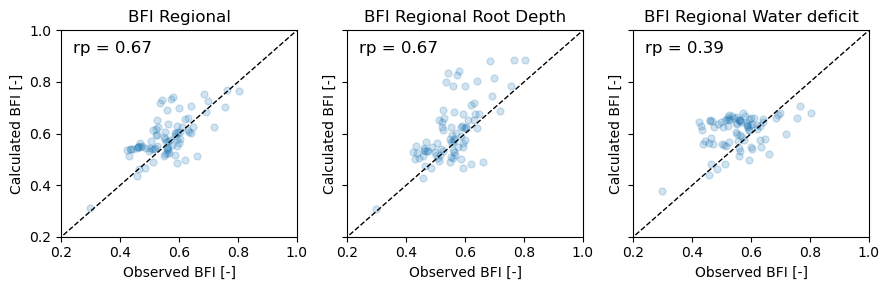

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_rd1', 'bfi_wd1']
titles = ['BFI Regional', 'BFI Regional Root Depth', 'BFI Regional Water deficit']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val["bfi_obs"]
    y = data_diff_val[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

In [70]:
inputstimesies = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="DERP2013"

inputstimesies["P"] = inputs[gauge_id][0]
inputstimesies["PET"] = inputs[gauge_id][2]


In [71]:
# For example, using mean values clearly for yearly aggregation:
inputstimesies_yearly = inputstimesies.resample("Y").sum()
inputstimesies_yearly

,P,PET
1988-12-31,918.62,752.15
1989-12-31,761.00,806.74
1990-12-31,817.36,812.31
1991-12-31,599.90,790.63
1992-12-31,798.06,792.08
1993-12-31,851.49,774.63
1994-12-31,876.86,781.38
1995-12-31,1011.65,757.39
1996-12-31,692.02,734.46
1997-12-31,827.05,771.72


In [73]:
inputstimesies.to_csv("inputstimesies_yearly.csv")

In [51]:
waterdeficit_mean

{'BEWA0066': 289.8,
 'BEWA0067': 271.9,
 'BEWA0087': 331.1,
 'BEWA0106': 331.3,
 'BEWA0107': 287.8,
 'BEWA0119': 292.3,
 'DEBU1956': 471.7,
 'DEBU1957': 542.2,
 'DEBU1958': 464.6,
 'DEBU1959': 459.4,
 'DERP2003': 420.5,
 'DERP2004': 301.9,
 'DERP2005': 332.9,
 'DERP2006': 287.8,
 'DERP2007': 381.6,
 'DERP2008': 380.2,
 'DERP2010': 394.7,
 'DERP2011': 433.4,
 'DERP2013': 720.0,
 'DERP2014': 493.4,
 'DERP2015': 507.6,
 'DERP2016': 595.6,
 'DERP2017': 443.0,
 'DERP2018': 445.8,
 'DERP2021': 320.8,
 'DERP2022': 375.6,
 'DERP2023': 403.6,
 'DERP2024': 456.0,
 'DERP2027': 449.0,
 'DERP2028': 455.6,
 'DERP2029': 494.2,
 'DERP2030': 452.0,
 'DERP2031': 433.9,
 'DERP2033': 525.6,
 'DERP2036': 629.9,
 'FR000124': 193.8,
 'FR000125': 203.3,
 'FR000126': 206.4,
 'FR000127': 206.7,
 'FR000128': 237.0,
 'FR000132': 249.9,
 'FR000133': 278.0,
 'FR000134': 288.5,
 'FR000135': 336.2,
 'FR000136': 471.1,
 'FR000137': 461.6,
 'FR000138': 474.3,
 'FR000139': 474.3,
 'FR000140': 392.9,
 'FR000142': 291.8,


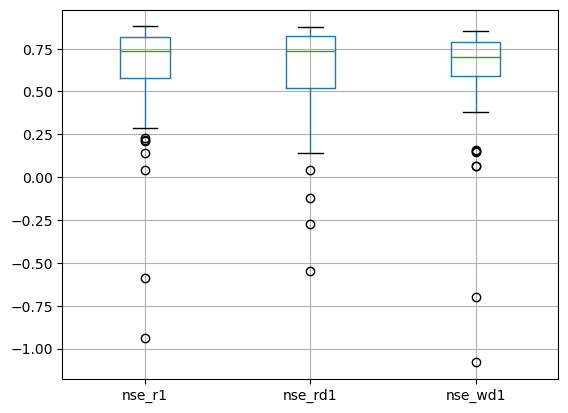

In [47]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_val[data_diff_val.nse_wd1 > -6].boxplot(column=["nse_r1","nse_rd1", "nse_wd1"])

# Show the plot
plt.show()


(0.2, 1.0)

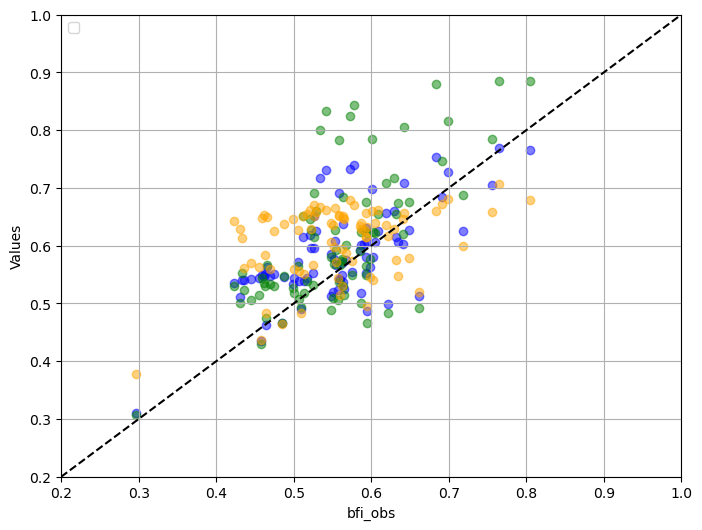

In [266]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_r1"], color='blue', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_rd1"], color='green', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_wd1"], color='orange',alpha=0.5)


# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])
